In [1]:
import pandas as pd
import numpy as np
import random
from functools import partial

%matplotlib inline
from matplotlib import pyplot

## Experiment 1: static vote counting

In [3]:
def count_votes(sampling_dist,nb_iter,condition):
    def check_quality(idx_ans):
        if condition.iloc[idx_ans]>random.random() :
            return idx_ans + 1
        return 0
                
    counts_cond = pd.concat([sampling_dist]*nb_iter,axis=1).apply(
                        lambda col: check_quality(col[col>random.random()].index[0]))
    return counts_cond[counts_cond>0].values

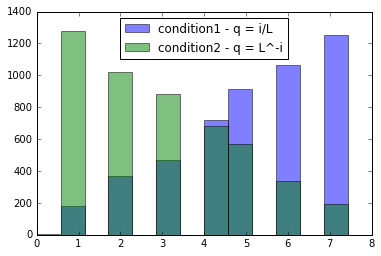

In [7]:

nb_iter = 10000
nb_ans = 8
pbias = pd.Series([1 - i/nb_ans for i in range(1,nb_ans+1)])
pbias = (pbias/pbias.sum()).cumsum()
count_experiment = partial(count_votes,pbias,nb_iter)

q1 = pd.Series([float(i)/nb_ans for i in range(1,nb_ans+1)])
q2 = pd.Series([1 - float(i)/nb_ans for i in range(1,nb_ans+1)])
#q2 = pd.Series([(nb_ans**-i) for i in range(1,nb_ans+1)])


bins = np.linspace(0, nb_ans, int((nb_ans-1)/0.5)+1)        
pyplot.hist(count_experiment(q1), bins, alpha=0.5,label='condition1 - q = i/L')
pyplot.hist(count_experiment(q2), bins, alpha=0.5,label='condition2 - q = L^-i')
pyplot.legend(loc='best')
pyplot.show()

## Experiment 2: do answers find a stable position?

In [8]:
from scipy.stats import beta

In [13]:
def sim_voting(sampling_dist,nb_iter,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    for _ in range(nb_iter):
        sample_idx = sampling_dist[sampling_dist>random.random()].index[0]
        if q_votes['q'].iloc[sample_idx]>random.random():
            q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
            q_votes = q_votes.sort_values(by=['votes'],ascending=False)
            q_votes.index = range(q_votes.shape[0])
    return q_votes

In [27]:
def run_exp(nb_ans=8,nb_iter=200):
    q_ans = pd.DataFrame({'ans':range(1,nb_ans+1),'q': sorted(np.random.uniform(0,1.0,nb_ans))})
    pbias = pd.Series([1-(float(i)+1)/nb_ans for i in range(1,nb_ans+1)])
    pbias = (pbias/pbias.sum()).cumsum()
    vote_experiment = partial(sim_voting,pbias,nb_iter)
    results1 = vote_experiment(q_ans)
    q_ans.rename(columns={'ans':'ans_init','q':'q_init'},inplace=True)
    res = pd.concat([results,q_ans],axis=1)
    res = res.reset_index(level=[0],drop=False)
    res = pd.merge(res[['index','ans']],res[['index','ans_init']],
         how='inner',left_on='ans',right_on='ans_init',suffixes=['_res','_init'])
    pos:ans goes up neg:ans goes down
    return (res['index_init'] - res['index_res']).values

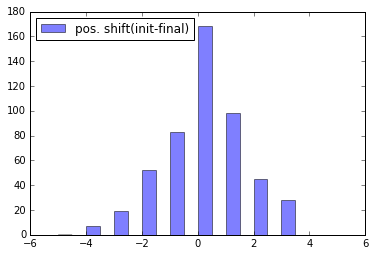

In [119]:
shift_values = np.array([])
nb_ans = 5
nb_exp = 100
for _ in range(nb_exp):
    shift_values = np.hstack([shift_values,run_exp(nb_ans=nb_ans)])

bins = np.linspace(-nb_ans, nb_ans, int((2*nb_ans)/0.5)+1)        
pyplot.hist(shift_values, bins, alpha=0.5,label='pos. shift(init-final)')
pyplot.legend(loc='best')
pyplot.show()